Cells #1-3 are adapted from Piper inferencing notebook (by [rmcpantoja](http://github.com/rmcpantoja) and [Xx_Nessu_xX](https://github.com/XxNessuxX/) ). The rest was written originally here.

In [ ]:
lang_select = "English"
lang = "en"
use_gpu = False

%cd /content
print("\033[93mInstalling...")

!git clone -q https://github.com/rmcpantoja/piper
%cd /content/piper/src/python
!pip install -q cython>=0.29.0 piper-phonemize==1.1.0 librosa>=0.9.2 numpy>=1.26 onnxruntime>=1.19.0 pytorch-lightning
!pip install -q --upgrade gdown pydub
!bash build_monotonic_align.sh
import os
if not os.path.exists("/content/piper/src/python/lng"):
  !cp -r "/content/piper/notebooks/lng" /content/piper/src/python/lng
import sys
sys.path.append('/content/piper/notebooks')
from translator import *
lan = Translator()
print("\033[93mChecking GPU...")
gpu_info = !nvidia-smi
if use_gpu and any('not found' in info for info in gpu_info[0].split(':')):
    raise Exception(lan.translate(lang, "The Use GPU checkbox is checked, but you don't have a GPU runtime."))
elif not use_gpu and not any('not found' in info for info in gpu_info[0].split(':')):
    raise Exception(lan.translate(lang, "The Use GPU checkbox is unchecked, however you are using a GPU runtime environment. We recommend you check the checkbox to use GPU to take advantage of it."))

print("\033[93mSuccess!")

/content
Installing...
/content/piper/src/python
Compiling /content/piper/src/python/piper_train/vits/monotonic_align/core.pyx because it changed.
[1/1] Cythonizing /content/piper/src/python/piper_train/vits/monotonic_align/core.pyx
/usr/local/lib/python3.11/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/piper/src/python/piper_train/vits/monotonic_align/core.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
performance hint: core.pyx:7:5: Exception check on 'maximum_path_each' will always require the GIL to be acquired.
Possible solutions:
	1. Declare 'maximum_path_each' as 'noexcept' if you control the definition and you're sure you don't want the function to raise exceptions.
	2. Use an 'int' return type on 'maximum_path_each' to allow an error code to be returned.
performance hint: core.pyx:38:6: Exception check on 'maximum_path_c' will alway

In [ ]:
%cd /content/piper/src/python
import os
#@markdown #### <font color="orange">**Model ID or link (ckpt format):**
model_url_or_id = "https://drive.google.com/file/d/1-cqt6_DUjqrgO0uvLdsK3PA855Xe4mGBO/view?usp=sharing" #@param {type:"string"}
if model_url_or_id == "" or model_url_or_id == "http" or model_url_or_id == "1":
    raise Exception(lan.translate(lang, "Invalid link or ID!"))
print("\033[93mDownloading model...")
if model_url_or_id.startswith("1"):
    !gdown -q "{model_url_or_id}"
elif model_url_or_id.startswith("https://drive.google.com/file/d/"):
    !gdown -q "{model_url_or_id}" --fuzzy
else:
    !wget -q "{model_url_or_id}"
#@markdown ---
#@markdown #### <font color="orange">**ID or URL of the config.json file:**
config_url_or_id = "https://drive.google.com/file/d/1-00jr5En5-l773leGsTBO5xR7lpRyWXc/view?usp=sharing" #@param {type:"string"}
if config_url_or_id.startswith("1"):
    !gdown -q "{config_url_or_id}"
elif config_url_or_id.startswith("https://drive.google.com/file/d/"):
    !gdown -q "{config_url_or_id}" --fuzzy
else:
    !wget -q "{config_url_or_id}"
#@markdown ---
print("\033[93mVoice package downloaded!")

/content/piper/src/python
Voice package downloaded!


In [ ]:
%cd /content/piper/src/python
# original: infer.py
!pip install -q peft transformers datasets
from peft import LoraConfig, LoraModel
import json
import logging
import sys
from pathlib import Path
from enum import Enum
from typing import Iterable, List, Optional, Union
import torch
from piper_train.vits.lightning import VitsModel
from piper_train.vits.wavfile import write as write_wav
import numpy as np
import glob
import ipywidgets as widgets
from IPython.display import display, Audio, Markdown, clear_output
from piper_phonemize import phonemize_codepoints, phonemize_espeak, tashkeel_run
import time
from pydub import AudioSegment
import scipy

def detect_ckpt_models(path):
    ckpt_models = glob.glob(path + '/*.ckpt')
    if len(ckpt_models) > 1:
        return ckpt_models
    elif len(ckpt_models) == 1:
        return ckpt_models[0]
    else:
        return None

def load_ckpt(model):
    _LOGGER.debug("Loading model from %s", model)
    config = load_config(model)
    model = VitsModel.load_from_checkpoint(str(model), dataset=None)
    # Inference only
    model.eval()
    with torch.no_grad():
        model.model_g.dec.remove_weight_norm()

    _LOGGER.info("Loaded model from %s", model)
    return model, config

def load_config(model):
    with open("config.json", "r") as file:
        config = json.load(file)
    return config

_LOGGER = logging.getLogger("piper_train.infer_onnx")
models_path = "/content/piper/src/python"
logging.basicConfig(level=logging.DEBUG)
model = None
ckpt_models = detect_ckpt_models(models_path)
speaker_selection = widgets.Dropdown(
    options=[],
    description=f'{lan.translate(lang, "Select speaker")}:',
    layout={'visibility': 'hidden'}
)
if ckpt_models is None:
    raise Exception(lan.translate(lang, "No downloaded voice packages!"))
elif isinstance(ckpt_models, str):
    ckpt_model = ckpt_models
    model, config = load_ckpt(ckpt_model)

/content/piper/src/python


/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Removing weight norm...


In [ ]:
ckpt_model = ckpt_models
model1, config1 = load_ckpt(ckpt_model)
model2, config2 = load_ckpt(ckpt_model)

Removing weight norm...
Removing weight norm...


In [ ]:
names_mod_g = []
not_incl = []
for name, module in model1.model_g.named_modules():
  if (isinstance(module, torch.nn.Conv1d)):
    names_mod_g.append('model_g.' + name)
  elif (isinstance(module, torch.nn.Embedding)):
    names_mod_g.append('model_g.' + name)
  else:
    not_incl.append('model_g.' + name)

In [ ]:
names_mod_d = []
for name, module in model1.model_d.named_modules():
  if (isinstance(module, torch.nn.Conv1d)):
    names_mod_d.append('model_d.' + name)

In [ ]:
names = names_mod_d + names_mod_g

In [ ]:
original_trainable_params = sum(p.numel() for p in model1.parameters())

In [ ]:
lora_config1 = LoraConfig(r=8,
    lora_alpha=8,
    target_modules = names,
    lora_dropout=0.01,)

In [ ]:
lora_model1 = LoraModel(model1, lora_config1, "default")

In [ ]:
new_trainable_params1 = sum(p.numel() for p in lora_model1.parameters()) - original_trainable_params

In [ ]:
lora_config2 = LoraConfig(r=16,
    lora_alpha=8,
    target_modules = names,
    lora_dropout=0.01,)

In [ ]:
lora_model2 = LoraModel(model2, lora_config2, "default")

In [ ]:
new_trainable_params2 = sum(p.numel() for p in lora_model2.parameters()) - original_trainable_params

In [ ]:
reduction1 = new_trainable_params1/original_trainable_params
reduction2 = new_trainable_params2/original_trainable_params
reduction1, reduction2

(0.024295371231106783, 0.048590742462213565)

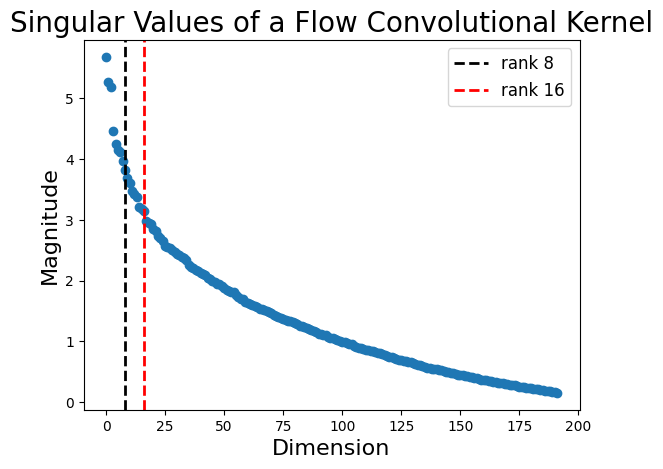

In [ ]:
import matplotlib.pyplot as plt
Uf,Sf,Vf = np.linalg.svd(model.state_dict()['model_g.flow.flows.2.enc.in_layers.1.weight_v'][:,:,0])
plt.scatter(range(len(Sf)),Sf)
plt.title('Singular Values of a Flow Convolutional Kernel', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 16)
plt.xlabel('Dimension', fontsize = 16)
plt.axvline(x=8, color='black', linestyle='--', linewidth=2, label = 'rank 8')
plt.axvline(x=16, color='r', linestyle='--', linewidth=2, label = 'rank 16')
plt.legend(fontsize = 12)
# plt.savefig('FlowRankGood.png',bbox_inches='tight')

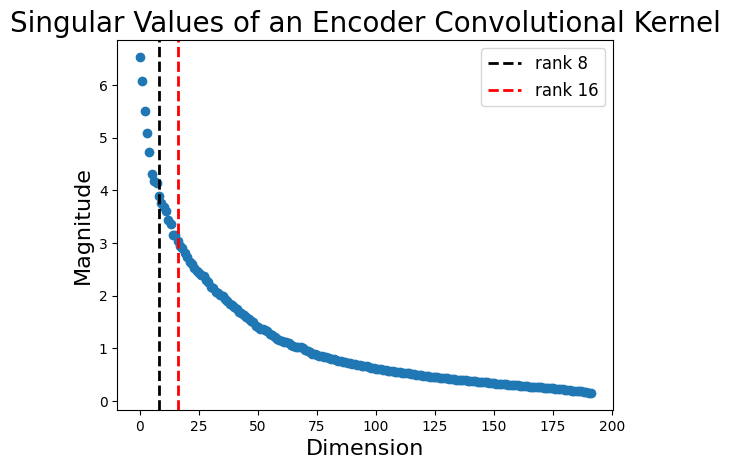

In [ ]:
Ue,Se,Ve = np.linalg.svd(model.state_dict()['model_g.enc_q.enc.in_layers.6.weight_v'][:,:,0])
plt.scatter(range(len(Se)),Se)
plt.title('Singular Values of an Encoder Convolutional Kernel', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 16)
plt.xlabel('Dimension', fontsize = 16)
plt.axvline(x=8, color='black', linestyle='--', linewidth=2, label = 'rank 8')
plt.axvline(x=16, color='r', linestyle='--', linewidth=2, label = 'rank 16')
plt.legend(fontsize = 12)
# plt.savefig('EncRankGood.png',bbox_inches='tight')

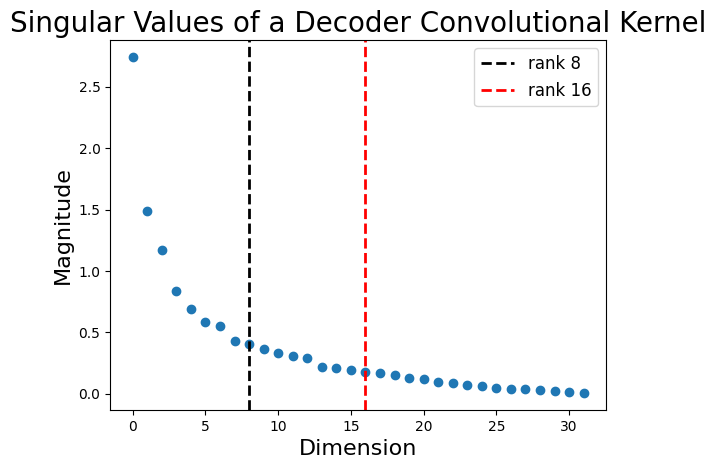

In [ ]:
Ud,Sd,Vd = np.linalg.svd(model.state_dict()['model_g.dec.resblocks.8.convs.1.weight'][:,:,0])
plt.scatter(range(len(Sd)),Sd)
plt.title('Singular Values of a Decoder Convolutional Kernel', fontsize = 20)
plt.ylabel('Magnitude', fontsize = 16)
plt.xlabel('Dimension', fontsize = 16)
plt.axvline(x=8, color='black', linestyle='--', linewidth=2, label = 'rank 8')
plt.axvline(x=16, color='r', linestyle='--', linewidth=2, label = 'rank 16')
plt.legend(fontsize = 12)
# plt.savefig('DecRankGood.png',bbox_inches='tight')

In [ ]:
flow_var_capt_8 = np.sum(Sf[:8])/np.sum(Sf)
flow_var_capt_16 = np.sum(Sf[:16])/np.sum(Sf)
enc_var_capt_8 = np.sum(Se[:8])/np.sum(Se)
enc_var_capt_16 = np.sum(Se[:16])/np.sum(Se)
dec_var_capt_8 = np.sum(Sd[:8])/np.sum(Sd)
dec_var_capt_16 = np.sum(Sd[:16])/np.sum(Sd)

In [ ]:
print(flow_var_capt_8, ' ', flow_var_capt_16)
print(enc_var_capt_8, ' ', enc_var_capt_16)
print(dec_var_capt_8, ' ', dec_var_capt_16)

0.14032917   0.24543318
0.18323606   0.30995807
0.7045768   0.8965321
